In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
train = datasets.MNIST( #train 데이터가 이미지와 라벨 두개로 이루어짐 (image, label)
    root='dataset',
    train = True,
    download=True,
    transform=transforms.ToTensor()
)
test = datasets.MNIST(
    root='dataset',
    train = False,
    download=True,
    transform=transforms.ToTensor()
)

In [4]:
train_x, val_x, _, _ = train_test_split(
    range(len(train)),
    train.targets,
    stratify=train.targets,
    test_size=0.2
)

In [5]:
train = Subset(train, train_x)
val = Subset(train, val_x)

In [6]:
batch_size = 128
train_batches = DataLoader(train, batch_size=batch_size, shuffle=True)
val_batches = DataLoader(train, batch_size=batch_size, shuffle=True)
test_batches = DataLoader(test, batch_size=batch_size, shuffle=False)

In [7]:
x_train, y_train = next(iter(train_batches)) #128개의 이미지와 128개의 라벨
print (x_train.shape, y_train.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [8]:
x_train[1, :, :, :].shape

torch.Size([1, 28, 28])

In [9]:
x_train[1, :, :, :].numpy( ).reshape(28,28).shape

(28, 28)

In [10]:
type(x_train[1, :, :, :].numpy()) #텐서 에다가 .numpy()를 붙이면 ndarray가 된다

numpy.ndarray

In [11]:
type(x_train[1, :, :, :])

torch.Tensor

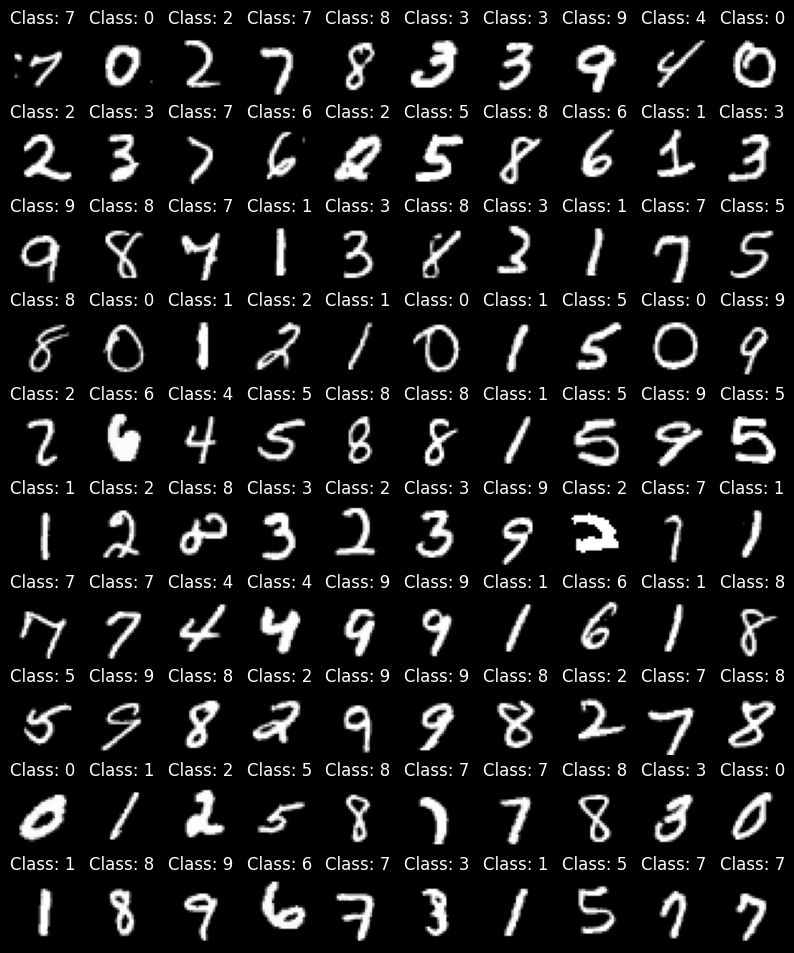

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,12))

x_train, y_train = next(iter(train_batches))
for i in range(100):
    plt.subplot(10,10, i+1)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28,28), cmap='gray')
    plt.title('Class: '+str(y_train[i].item()))

In [13]:
class FunModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.go = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, output_dim),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self,x):
        return self.go(x)

batch_size = 128
input_dim = 28 * 28
output_dim = 10
model = FunModel(input_dim, output_dim)
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
from copy import deepcopy

def train_model(model, early_stop, n_epochs, progress_interval):

    train_losses, valid_losses, lowest_loss = [], [], np.inf

    for i in range(1000):
        t_loss, v_loss = 0, 0
        model.train()
        for x,y in train_batches:
            y_pred = model(x.view(x.size(0),-1))
            loss = loss_func(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_loss = loss.item()
        t_loss = t_loss/len(train_batches)
        train_losses.append(t_loss)

        model.eval()
        with torch.no_grad():
            for x,y in val_batches:
                y_pred = model(x.view(x.size(0),-1))
                loss = loss_func(y_pred, y)
                v_loss+=loss.item()
        v_loss = v_loss /len(val_batches)
        valid_losses.append(v_loss)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_index = i
            best_model = deepcopy(model.state_dict())
        else:
            if(early_stop>0) and lowest_index + early_stop <i:
                print('일찍 끝남')
                break

        if i%progress_interval==0:
            print(train_losses[-1], valid_losses[-1], lowest_loss, lowest_index, i)
    model.load_state_dict(best_model)
    return model, lowest_loss, valid_losses

In [15]:
nb_epochs = 30
progress_interval = 3
early_stop = 10

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.0005667512019475301 0.1626596393287182 0.1626596393287182 0 0
0.00025463831424713137 0.05200697662681341 0.05200697662681341 3 3
0.0001786386768023173 0.022394842963976164 0.022394842963976164 6 6
0.00015211397409439087 0.014917044852705051 0.014917044852705051 9 9
4.573972274859747e-06 0.009600101731989222 0.009600101731989222 12 12
0.00014590837558110556 0.025398663620930163 0.009600101731989222 12 15


KeyboardInterrupt: 